In [1]:
import sys

sys.path.append('../')

import rings2cosmo
import pandas as pd

### Using 80 objects

In [16]:
data_80 = pd.read_csv('../data/sample80.csv')
data_80.head()

,name,zl,zs,sigma_0,dsigma_0,theta_E,theta_ap,sigma_atm,sigma_ap,d_sigma_ap
0,J2321-0939,0.082,0.532,246,8,1.60,1.5,1.4,249,8
1,J1106+5228,0.096,0.407,268,13,1.23,1.5,1.4,262,13
2,J1143-0144,0.106,0.402,264,13,1.68,1.5,1.4,269,13
3,J0841+3824,0.116,0.657,222,11,1.41,1.5,1.4,225,11
4,J0044+0113,0.120,0.196,267,13,0.79,1.5,1.4,266,13


In [17]:
len(data_80)

80

In [18]:
data = data_80
z_L = data['zl'].values
z_S = data['zs'].values
theta_E = (data['theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['sigma_atm'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['sigma_ap'].values
velDispErr = data['d_sigma_ap'].values

In [19]:
rings2cosmo.minimization_loglikelihood(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                               seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4)

(1.8620708369425902, 0.14371745788692236, 0.7686344288357998)

In [20]:
rings2cosmo.minimization_logprobability(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                                seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4, \
                                alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13)

(1.995536303344409, 0.17999999436099476, 0.9955441328208933)

In [21]:
rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 1000, progress = True, processes = 10)

Running burn-in ...


100%|██████████| 500/500 [00:20<00:00, 23.91it/s]


Sampling ...


100%|██████████| 1000/1000 [00:39<00:00, 25.07it/s]


In [22]:
sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 10)

Running burn-in ...


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Sampling ...


100%|██████████| 10000/10000 [06:50<00:00, 24.34it/s]


In [23]:
import matplotlib.pyplot as plt

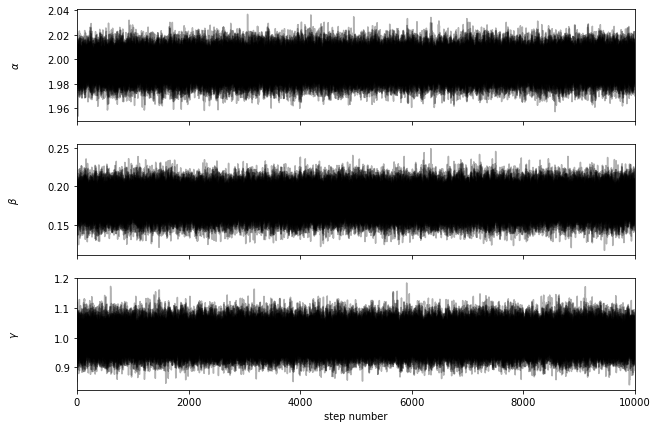

In [24]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [25]:
tau = sampler.get_autocorr_time()
print(tau)

[37.94798099 39.06679757 36.48419428]


In [26]:
flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
print(flat_samples.shape)

(15168, 3)


In [27]:
"Mean acceptance fraction: {0:.3f}".format(rings2cosmo.np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.646'

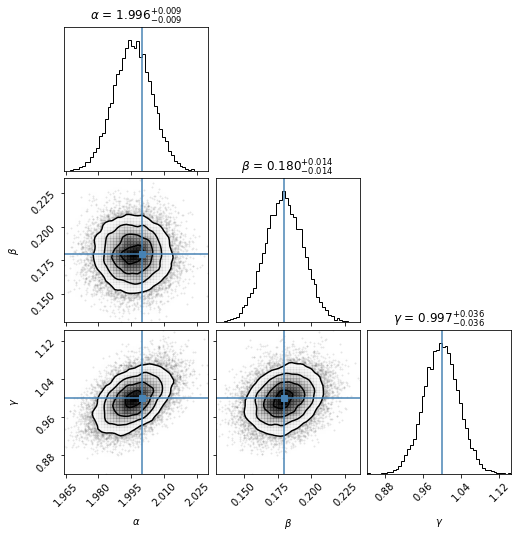

In [28]:
import corner

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

fig = corner.corner(
    flat_samples, bins=50, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

In [29]:
import numpy as np
from IPython.display import display, Math


labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
g = flat_samples[:, 2]

def gaussian(x, mean, amplitude, s0):
    return amplitude * np.exp( - (x - mean)**2 / 2 /s0**2)

In [31]:
from scipy.optimize import curve_fit

gamma: 0.997209597387956 \pm 0.00021397116834728644
sigma: 0.0365173277207665 \pm 0.0002139714663009532


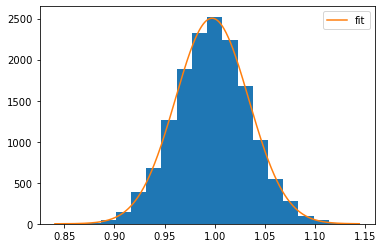

In [32]:
bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
print('gamma:',popt[0],'\pm',perr[0])
print('sigma:',popt[2],'\pm',perr[2])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

### Using 103 objects

In [29]:
data_103 = pd.read_csv('../data/sample103.csv')
data_103.head()

,name,zl,zs,sigma_0,dsigma_0,theta_E,theta_ap,sigma_atm,sigma_ap,d_sigma_ap
0,J0151+0049,0.517,1.364,226.0,40.0,0.68,1.0,1.8,219.0,39.0
1,J0747+4448,0.437,0.897,277.0,51.0,0.61,1.0,1.8,281.0,52.0
2,J0830+5116,0.530,1.332,274.0,37.0,1.14,1.0,1.8,268.0,36.0
3,J0944-0147,0.539,1.179,207.0,35.0,0.72,1.0,1.8,204.0,34.0
4,J1215+0047,0.642,1.297,266.0,46.0,1.37,1.0,1.8,262.0,45.0


In [30]:
len(data_103)

103

In [31]:
data = data_103
z_L = data['zl'].values
z_S = data['zs'].values
theta_E = (data['theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['sigma_atm'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['sigma_ap'].values
velDispErr = data['d_sigma_ap'].values

In [32]:
rings2cosmo.minimization_loglikelihood(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                               seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4)

(1.8336042011727829, 0.06325736424356097, 0.736016357202466)

In [33]:
rings2cosmo.minimization_logprobability(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                                seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4, \
                                alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13)

/share/storage1/TNG/Softwares/anaconda3-2020.02/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(1.9928877214454155, 0.17999999048891596, 1.0304422863468725)

In [35]:
sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = 2.0, beta_ini = 0.18, gamma_ini = 1.0, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 10)

Running burn-in ...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 46.37it/s]


Sampling ...


100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:38<00:00, 45.70it/s]


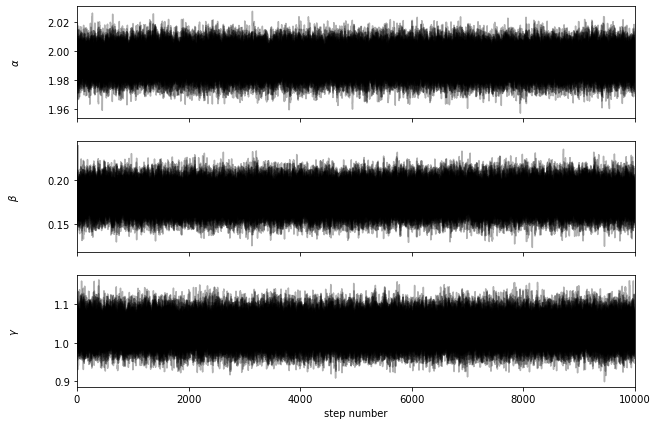

In [36]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [37]:
tau = sampler.get_autocorr_time()
print(tau)

[38.2388886  36.62601351 37.98981863]


In [38]:
flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
print(flat_samples.shape)

(15168, 3)


In [39]:
"Mean acceptance fraction: {0:.3f}".format(rings2cosmo.np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.647'

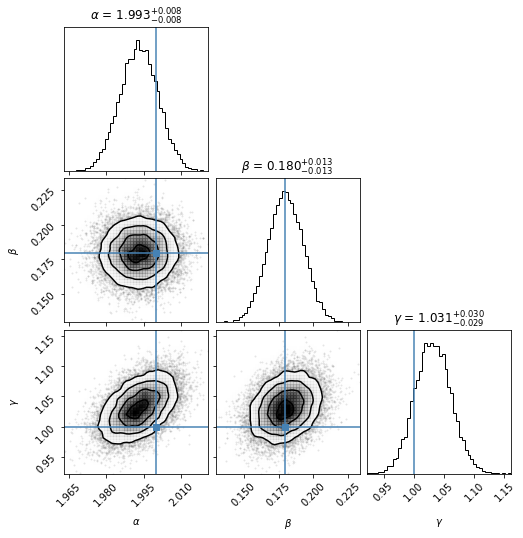

In [40]:
alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

fig = corner.corner(
    flat_samples, bins=50, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

In [41]:
labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [42]:
g = flat_samples[:, 2]

gamma: 1.0309878731755548 \pm 0.0002626286912954902
sigma: 0.029993609181210443 \pm 0.00026263394060258884


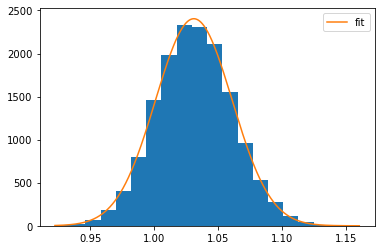

In [43]:
bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
print('gamma:',popt[0],'\pm',perr[0])
print('sigma:',popt[2],'\pm',perr[2])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()